# Deuxième partie : Détection des tumeurs cérébrales avec YOLOv8

Cette partie consiste à classer les images de tumeurs cérébrales et à localiser les tumeurs à l'aide du modèle YOLOv8.

In [2]:
# Imports et configuration initiale


## 1. Afficher un échantillon d'images pour chaque classe avec les boîtes englobantes

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Classes : ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']


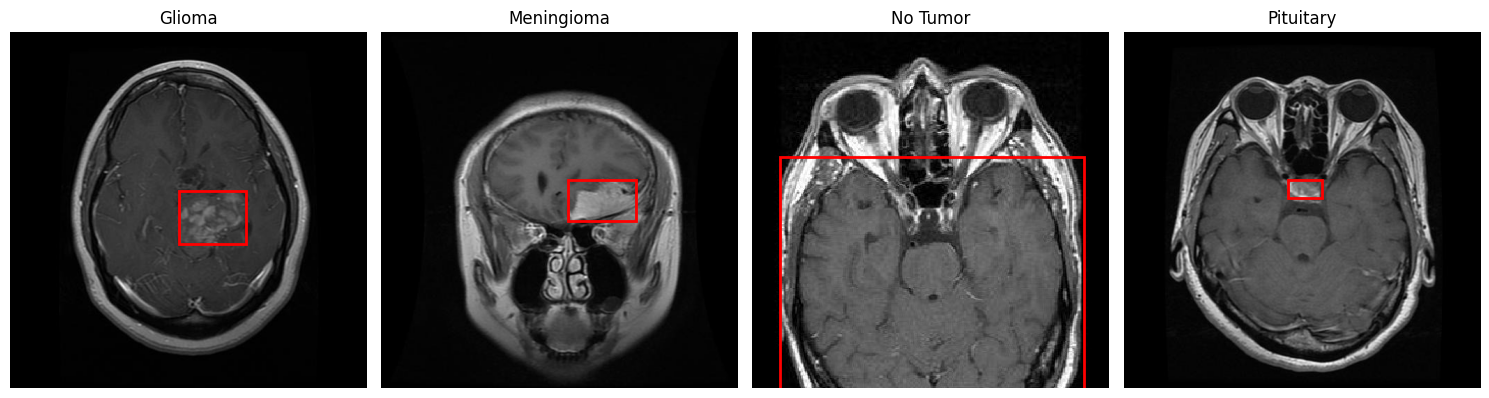

In [3]:
import os
%pip install Pillow
from PIL import Image
%pip install matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Dossier racine du dataset
data_dir = "../Data/Raw/Data_Brain/Train"

# Récupérer les noms des classes (dossiers)
classes = os.listdir(data_dir)
print("Classes :", classes)

# Fonction pour convertir les coordonnées YOLO en coordonnées d'image
def yolo_to_box(x_center, y_center, width, height, img_width, img_height):
    x_min = (x_center - width / 2) * img_width
    y_min = (y_center - height / 2) * img_height
    box_width = width * img_width
    box_height = height * img_height
    return x_min, y_min, box_width, box_height

# Afficher une image pour chaque classe
plt.figure(figsize=(15, 5))

for i, cls in enumerate(classes):
    img_dir = os.path.join(data_dir, cls, "images")
    label_dir = os.path.join(data_dir, cls, "labels")

    # Prendre la première image et son label correspondant
    img_name = os.listdir(img_dir)[0]
    label_name = os.path.splitext(img_name)[0] + ".txt"

    img_path = os.path.join(img_dir, img_name)
    label_path = os.path.join(label_dir, label_name)

    # Ouvrir l’image
    img = Image.open(img_path).convert("RGB")
    img_w, img_h = img.size

    # Lire le fichier d’annotation
    with open(label_path, "r") as f:
        lines = f.readlines()

    # Afficher l’image
    ax = plt.subplot(1, len(classes), i + 1)
    ax.imshow(img)
    ax.set_title(cls)
    ax.axis("off")

    # Dessiner les boîtes englobantes
    for line in lines:
        parts = line.strip().split()
        if len(parts) < 5:
            continue
        _, x, y, w, h = map(float, parts)
        x_min, y_min, bw, bh = yolo_to_box(x, y, w, h, img_w, img_h)
        rect = patches.Rectangle(
            (x_min, y_min), bw, bh, linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)

plt.tight_layout()
plt.show()


## 3. Filtrer et copier les images et labels

Pour chaque image :
- Vérifier si un fichier .txt correspondant existe dans le répertoire des labels
- Si un label est trouvé : copier l'image et le label vers le dossier approprié (train/valid/test)
- Si aucun label n'est trouvé : afficher un avertissement et sauter l'image

In [4]:
import os
import shutil

# === 1 Dossiers source et sortie ===
source_dir = "../Data/Raw/Data_Brain"   # Ton dataset
output_dir = "../Data/outputpath"      # Nouveau dossier de sortie

# Créer le dossier de sortie et ses sous-dossiers
for sub in ["images", "labels"]:
    for split in ["Train", "Val"]:
        path = os.path.join(output_dir, sub, split)
        os.makedirs(path, exist_ok=True)

print(" Dossiers créés avec succès !")

# === 2 Extensions d’images acceptées ===
valid_ext = (".jpg", ".jpeg", ".png", ".bmp")

# === 3 Parcourir Train et Val ===
for split in ["Train", "Val"]:
    split_path = os.path.join(source_dir, split)

    print(f"\n🔹 Traitement de {split_path}")

    # Parcourir les classes (Glioma, Meningioma, etc.)
    for cls in os.listdir(split_path):
        class_path = os.path.join(split_path, cls)
        if not os.path.isdir(class_path):
            continue

        img_folder = os.path.join(class_path, "images")
        label_folder = os.path.join(class_path, "labels")

        if not os.path.exists(img_folder) or not os.path.exists(label_folder):
            print(f"⚠️ {cls} n’a pas de dossier images ou labels.")
            continue

        for img_name in os.listdir(img_folder):
            if not img_name.lower().endswith(valid_ext):
                continue

            label_name = os.path.splitext(img_name)[0] + ".txt"
            img_path = os.path.join(img_folder, img_name)
            label_path = os.path.join(label_folder, label_name)

            if os.path.exists(label_path):
                shutil.copy(img_path, os.path.join(output_dir, "images", split, img_name))
                shutil.copy(label_path, os.path.join(output_dir, "labels", split, label_name))
            else:
                print(f"⚠️ Pas de label pour {img_name}")

print("\n✅ Copie terminée avec succès ! Seules les images avec labels ont été copiées.")


 Dossiers créés avec succès !

🔹 Traitement de ../Data/Raw/Data_Brain\Train

🔹 Traitement de ../Data/Raw/Data_Brain\Val
⚠️ Pas de label pour image(55).jpg
⚠️ Pas de label pour image(61).jpg

✅ Copie terminée avec succès ! Seules les images avec labels ont été copiées.


## 4. Créer le fichier data.yaml sans augmentations

Ce fichier contient :
- Les chemins des dossiers d'entraînement, de validation et de test
- Le nombre de classes et le nom de chaque classe
- Configuration sans augmentations de données

In [5]:
%pip install pyyaml
import yaml

data_config = {
    'train': 'Data/outputpath/images/Train',
    'val': 'Data/outputpath/images/Val',
    'nc': 4,
    'names': ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'],
    'augment': False
}

with open('../data.yaml', 'w') as file:
    yaml.dump(data_config, file)

print("✅ Fichier data2.yaml créé avec succès (avec augmentations desactivées) !")


Note: you may need to restart the kernel to use updated packages.
✅ Fichier data2.yaml créé avec succès (avec augmentations desactivées) !



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## 5. Créer le fichier data2.yaml avec augmentations

Ce fichier contient la même structure que data.yaml mais avec des augmentations de données activées

In [6]:
import yaml

data2_config = {
    'train': 'Data/outputpath/images/Train',
    'val': 'Data/outputpath/images/Val',
    'nc': 4,
    'names': ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'],
    'augment': True
}

with open('../data2.yaml', 'w') as file:
    yaml.dump(data2_config, file)

print("✅ Fichier data2.yaml créé avec succès (avec augmentations activées) !")


✅ Fichier data2.yaml créé avec succès (avec augmentations activées) !


## 6. Compter le nombre d'images et d'étiquettes

Compter les images et labels présents dans les ensembles d'entraînement et de validation

In [7]:
import os

train_images = '../Data/outputpath/images/Train'
train_labels = '../Data/outputpath/labels/Train'
valid_images = '../Data/outputpath/images/Val'
valid_labels = '../Data/outputpath/labels/Val'

train_img_count = len([f for f in os.listdir(train_images) if f.endswith(('.jpg', '.png', '.jpeg'))])
train_label_count = len([f for f in os.listdir(train_labels) if f.endswith('.txt')])
valid_img_count = len([f for f in os.listdir(valid_images) if f.endswith(('.jpg', '.png', '.jpeg'))])
valid_label_count = len([f for f in os.listdir(valid_labels) if f.endswith('.txt')])

print(f"tain:")
print(f"  - Images: {train_img_count}")
print(f"  - Labels: {train_label_count}")
print(f"\nvalidation")
print(f"  - Images: {valid_img_count}")
print(f"  - Labels: {valid_label_count}")

tain:
  - Images: 4737
  - Labels: 4737

validation
  - Images: 510
  - Labels: 510


## 7. Vérifier la correspondance images-labels et nettoyer les données

- Vérifier que chaque image possède un label correspondant
- Supprimer les images sans label
- Supprimer les labels sans image correspondante

In [8]:
import os

datasets = {
    'train': {
        'images': '../Data/outputpath/images/Train',
        'labels': '../Data/outputpath/labels/Train'
    },
    'valid': {
        'images': '../Data/outputpath/images/Val',
        'labels': '../Data/outputpath/labels/Val'
    }
}

def verify_and_clean(images_dir, labels_dir):
    if not os.path.exists(images_dir) or not os.path.exists(labels_dir):
        print(f"Les répertoires {images_dir} ou {labels_dir} n'existent pas.")
        return
    
    images = {os.path.splitext(f)[0]: f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))}
    labels = {os.path.splitext(f)[0]: f for f in os.listdir(labels_dir) if f.endswith('.txt')}
    
    images_removed = 0
    labels_removed = 0
    
    for img_name in list(images.keys()):
        if img_name not in labels:
            os.remove(os.path.join(images_dir, images[img_name]))
            images_removed += 1
            print(f"Image supprimée (pas de label): {images[img_name]}")
    
    for label_name in list(labels.keys()):
        if label_name not in images:
            os.remove(os.path.join(labels_dir, labels[label_name]))
            labels_removed += 1
            print(f"Label supprimé (pas d'image): {labels[label_name]}")
    
    remaining_count = len(images) - images_removed
    print(f"\nRésumé: {images_removed} images et {labels_removed} labels supprimés")
    print(f"Paires valides restantes: {remaining_count}\n")

for dataset_name, paths in datasets.items():
    print(f"=== Vérification de {dataset_name} ===")
    verify_and_clean(paths['images'], paths['labels'])

=== Vérification de train ===

Résumé: 0 images et 0 labels supprimés
Paires valides restantes: 4737

=== Vérification de valid ===

Résumé: 0 images et 0 labels supprimés
Paires valides restantes: 510



## 8. Entraîner le modèle YOLOv8

Lancer l'entraînement du modèle YOLO en définissant les hyperparamètres appropriés

In [12]:
%pip install ultralytics
from ultralytics import YOLO

model = YOLO('yolov8s.pt') 

model.train(
    data='../data.yaml',      
    epochs=100,             
    batch=-1,
    cos_lr=True,
    patience=10,                       
    device=0,    
    save=True,
    name='model2_yolov8s'          
)


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for ultralytics from https://files.pythonhosted.org/packages/4a/ba/c8c6bfead866e79b2dc5644145cbad41531e9c69b74e911e46c847312222/ultralytics-8.3.220-py3-none-any.whl.metadata
  Using cached ultralytics-8.3.220-py3-none-any.whl.metadata (37 kB)
  Obtaining dependency information for opencv-python>=4.6.0 from https://files.pythonhosted.org/packages/fa/80/eb88edc2e2b11cd2dd2e56f1c80b5784d11d6e6b7f04a1145df64df40065/opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata
  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
  Obtaining dependency information for requests>=2.23.0 from https://files.pythonhosted.org/packages/1e/db/4254e3eabe8020b458f1a747140d32277ec7a271daf1d235b70dc0b4e6e3/requests-2.32.5-py3-none-any.whl.metadata
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Obtaining dependency information for scipy>=1.4.1 from https://files.pythonhosted.org/packages/34/95/20e02ca66fb495a95fba0642fd48e0c390

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001ED480160C0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
       

In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
from ultralytics import YOLO

model = YOLO('yolov8s.pt') 

model.train(
    data='../data2.yaml',      
    epochs=100,             
    batch=-1,
    cos_lr=True,
    patience=10,                       
    device=0,    
    save=True,
    name='model_augm'
)

New https://pypi.org/project/ultralytics/8.3.221 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.220  Python-3.12.0 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 2000 Ada Generation Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=../data2.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=model_augm, nbs=64, nms=F

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002264ADE7CE0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
       

## 9. Évaluer et tester le modèle

Évaluer et tester le modèle après l'entraînement pour mesurer :
- Les performances
- La précision
- La capacité à généraliser sur des données inédites

In [3]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path


model_path = 'runs/detect/model2_yolov8s/weights/best.pt' 
model = YOLO(model_path)

print("Évaluation du modèle sur l'ensemble de validation...")

metrics = model.val(data='../data.yaml', split='val')

print("\nMétriques de performance:")
print(f"  - mAP50: {metrics.box.map50:.4f}")
print(f"  - mAP50-95: {metrics.box.map:.4f}")
print(f"  - Précision: {metrics.box.mp:.4f}")
print(f"  - Rappel (Recall): {metrics.box.mr:.4f}")

print("\n Métriques par classe:")
class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
for i, class_name in enumerate(class_names):
    print(f"  {class_name}:")
    print(f"    - Précision: {metrics.box.p[i]:.4f}")
    print(f"    - Rappel: {metrics.box.r[i]:.4f}")
    print(f"    - mAP50: {metrics.box.ap50[i]:.4f}")
    print(f"    - mAP50-95: {metrics.box.ap[i]:.4f}")

print("\nÉvaluation terminée!")


Évaluation du modèle sur l'ensemble de validation...
Ultralytics 8.3.220  Python-3.12.0 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 2000 Ada Generation Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 58.622.1 MB/s, size: 22.0 KB)
val: Scanning C:\Users\issam\OneDrive\Desktop\Cancers-sanguins-Tumeurs-c-r-brales-via-Transfer-Learning\Data\outputpath\labels\Val.cache... 510 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 510/510 254.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 32/32 5.3it/s 6.1s0.2s
                   all        510        554      0.969      0.932      0.966      0.804
                Glioma        135        153      0.943      0.889      0.941      0.772
            Meningioma        140        142      0.993      0.998      0.993      0.848
              No Tumor         98         98          1 

### 9.2 Tester le modèle sur des images de l'ensemble de validation

Visualiser les prédictions du modèle sur des échantillons d'images

In [4]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

if 'model' not in locals():
    model_path = 'runs/detect/model2_yolov8s/weights/best.pt'
    model = YOLO(model_path)

val_images_dir = '../Data/outputpath/images/Val'

all_images = [f for f in os.listdir(val_images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
sample_images = random.sample(all_images, min(6, len(all_images)))

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
colors = ['red', 'blue', 'green', 'orange']

for idx, img_name in enumerate(sample_images):
    img_path = os.path.join(val_images_dir, img_name)
    
    results = model.predict(source=img_path, conf=0.25, verbose=False)
    
    img = Image.open(img_path).convert('RGB')
    img_w, img_h = img.size
    
    axes[idx].imshow(img)
    axes[idx].axis('off')
    
    if len(results) > 0 and results[0].boxes is not None:
        boxes = results[0].boxes
        
        for i in range(len(boxes)):
            box = boxes.xyxy[i].cpu().numpy()
            conf = boxes.conf[i].cpu().numpy()
            cls = int(boxes.cls[i].cpu().numpy())
            
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            
            rect = patches.Rectangle(
                (x1, y1), width, height,
                linewidth=2,
                edgecolor=colors[cls],
                facecolor='none'
            )
            axes[idx].add_patch(rect)
            
            label = f'{class_names[cls]} {conf:.2f}'
            axes[idx].text(
                x1, y1 - 10,
                label,
                color='white',
                fontsize=10,
                bbox=dict(facecolor=colors[cls], alpha=0.7, edgecolor='none', pad=2)
            )
        
        axes[idx].set_title(f'Image: {img_name}', fontsize=10)
    else:
        axes[idx].set_title(f'Image: {img_name} (Aucune détection)', fontsize=10)

plt.tight_layout()
plt.show()

print("Prédictions affichées!")


<Figure size 1800x1200 with 6 Axes>

Prédictions affichées!


### 9.3 Matrice de confusion

Afficher la matrice de confusion pour analyser les performances du modèle par classe

In [5]:
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

confusion_matrix_path = 'runs/detect/model2_yolov8s/confusion_matrix.png'

if os.path.exists(confusion_matrix_path):
    img = Image.open(confusion_matrix_path)
    plt.figure(figsize=(12, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Matrice de confusion', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    print("Matrice de confusion affichée!")
else:
    print(f"La matrice de confusion n'a pas été trouvée à: {confusion_matrix_path}")
    print("Assurez-vous d'avoir exécuté l'entraînement ou la validation du modèle.")


<Figure size 1200x1000 with 1 Axes>

Matrice de confusion affichée!


### 9.4 Courbes de performance (Précision-Rappel et F1)

Afficher les courbes P-R et F1 générées pendant l'entraînement

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
import os

results_dir = 'runs/detect/model2_yolov8s'
plot_files = {
    'Courbe P-R': 'PR_curve.png',
    'Courbe F1': 'F1_curve.png',
    'Courbe P': 'P_curve.png',
    'Courbe R': 'R_curve.png'
}

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, (title, filename) in enumerate(plot_files.items()):
    file_path = os.path.join(results_dir, filename)
    
    if os.path.exists(file_path):
        img = Image.open(file_path)
        axes[idx].imshow(img)
        axes[idx].set_title(title, fontsize=14, fontweight='bold')
        axes[idx].axis('off')
    else:
        axes[idx].text(0.5, 0.5, f'{title}\nFichier non trouvé', 
                      ha='center', va='center', fontsize=12)
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("✅ Courbes de performance affichées!")


<Figure size 1600x1400 with 4 Axes>

✅ Courbes de performance affichées!


### 9.5 Résultats d'entraînement (Loss et mAP)

Afficher l'évolution des métriques pendant l'entraînement

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import os

results_path = 'runs/detect/model2_yolov8s/results.png'

if os.path.exists(results_path):
    img = Image.open(results_path)
    plt.figure(figsize=(16, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Évolution des métriques pendant l\'entraînement', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    print("Graphique des résultats d'entraînement affiché!")
else:
    print(f"Le fichier des résultats n'a pas été trouvé à: {results_path}")
    print("Assurez-vous d'avoir terminé l'entraînement du modèle.")


<Figure size 1600x1000 with 1 Axes>

Graphique des résultats d'entraînement affiché!


## 10. Sauvegarder le modèle entraîné

Sauvegarder le modèle entraîné pour une utilisation future